In [8]:
from IPython.display import HTML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,preprocessing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ,Resizing , InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [9]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [10]:
import zipfile

# Unzipping the dataset
zip_path = '/content/archive.zip'
extraction_path = 'melanoma_cancer_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [11]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    r'/content/melanoma_cancer_dataset/melanoma_cancer_dataset/train',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    r'/content/melanoma_cancer_dataset/melanoma_cancer_dataset/test',
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 9605 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [12]:
class_name = dataset_test.class_names

In [13]:
for image_batch, labels_batch in dataset_train.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0]


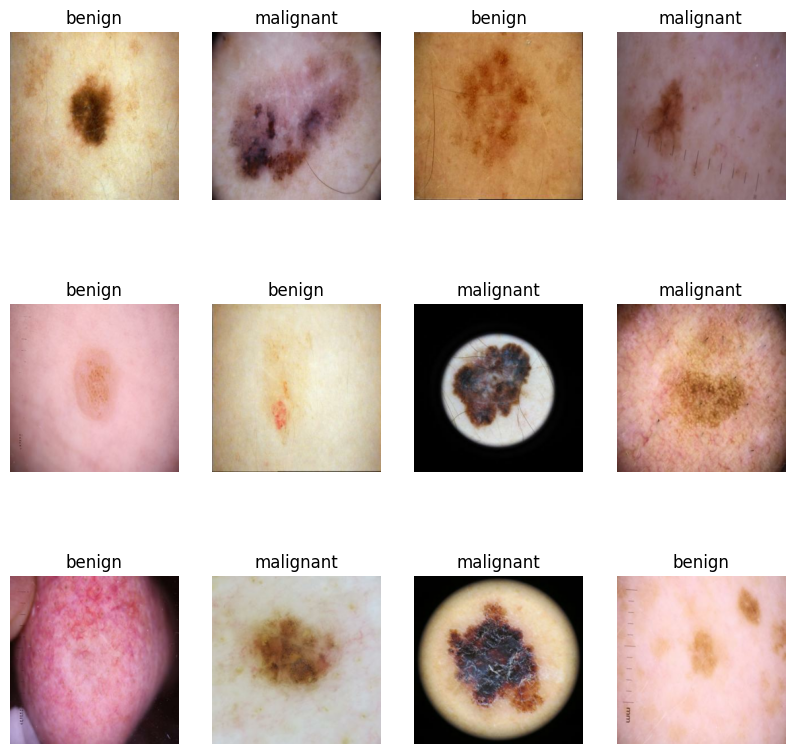

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset_train.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[labels_batch[i]])
        plt.axis("off")

In [15]:
val_size=0.2
len(dataset_test)*val_size

12.600000000000001

In [16]:
val_ds = dataset_test.take(6)
len(val_ds)

6

In [17]:
test_ds = dataset_test.skip(6)
len(test_ds)

57

In [18]:
len(dataset_test)

63

In [19]:
train_data = dataset_train

In [20]:
len(train_data)

601

In [21]:
def get_dataset_partitions_tf(ds, val_split=0.2, test_split=0.8, shuffle=True, shuffle_size=10000):
    assert ( test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    val_size = int(val_split * ds_size)

    val_ds = ds.take(val_size)
    test_ds = ds.skip(val_size)

    return val_ds, test_ds

In [22]:
val_ds, test_ds = get_dataset_partitions_tf(dataset_test)

In [23]:
len(val_ds)

12

In [24]:
len(test_ds)

51

In [25]:
len(train_data)

601

In [26]:
train_ds = train_data

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
IMAGE_SIZE = (256, 256)

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),  # Ensure input shape is defined here
    tf.keras.layers.Rescaling(1./255),
])

In [29]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [31]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = Sequential()

model.add(InputLayer(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(resize_and_rescale)
model.add(Conv2D(32, kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(n_classes,activation='sigmoid'))

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    optimizer='adam',
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 136s 186ms/step - accuracy: 0.7190 - loss: 0.5445 - val_accuracy: 0.8152 - val_loss: 0.4052
Epoch 2/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 106s 177ms/step - accuracy: 0.8449 - loss: 0.3665 - val_accuracy: 0.8696 - val_loss: 0.3386
Epoch 3/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 140s 174ms/step - accuracy: 0.8586 - loss: 0.3432 - val_accuracy: 0.7989 - val_loss: 0.5091
Epoch 4/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 105s 174ms/step - accuracy: 0.8581 - loss: 0.3389 - val_accuracy: 0.8098 - val_loss: 0.3780
Epoch 5/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 106s 176ms/step - accuracy: 0.8693 - loss: 0.3022 - val_accuracy: 0.8315 - val_loss: 0.3566


In [35]:
scores = model.evaluate(test_ds)

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8920 - loss: 0.2528


In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


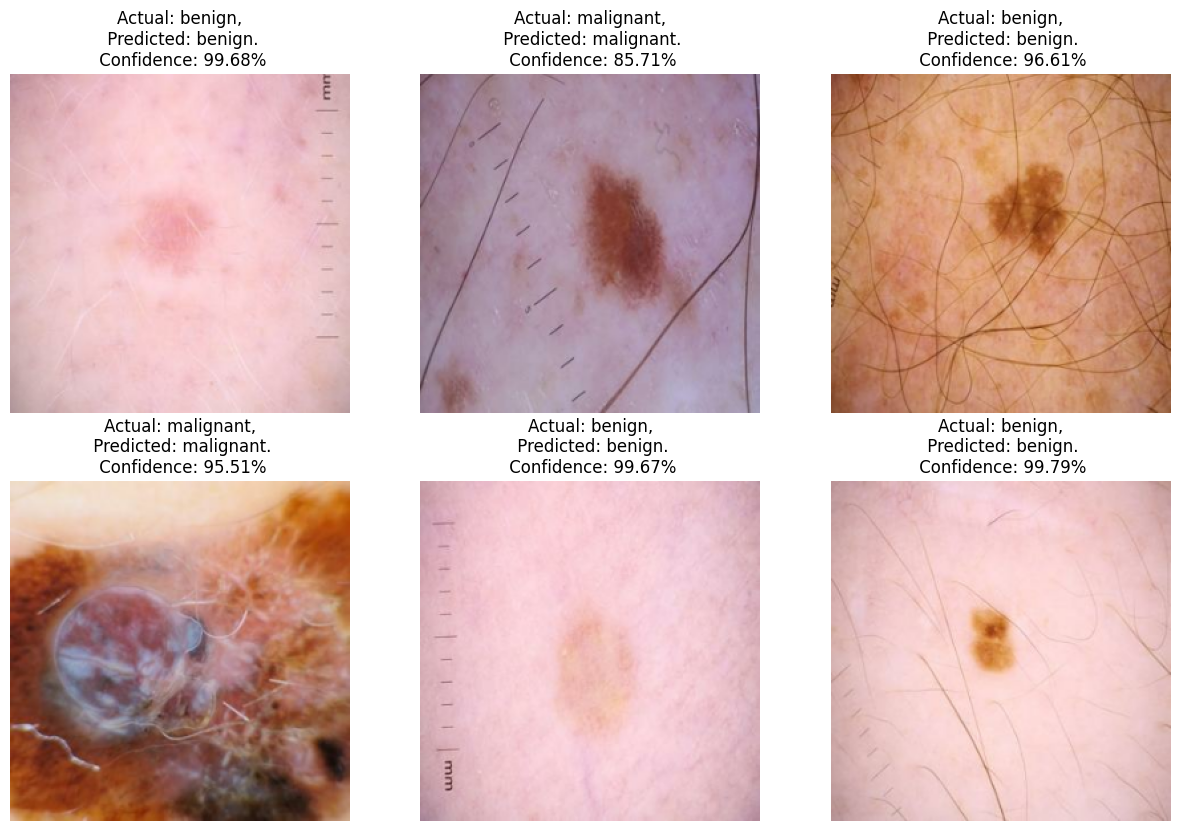

In [42]:
import numpy as np
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [43]:
model.save('My_model.h5')

In [39]:
import pickle

pickle.dump(model,open('Final_model_1','wb'))

In [40]:
model.save('Skin_model.keras',include_optimizer=False)

In [41]:
from tensorflow.keras.backend import clear_session
clear_session()